## 1.训练部分

In [1]:
import os, argparse

from data import *
from train import *
from model import *
from utils import *

### 1.1 配置超参数

In [2]:
parser = argparse.ArgumentParser(description="Pytorch distributed")

# 数据集参数
parser.add_argument('-data_size', '--data_size', type = int, default = 300000) 
parser.add_argument('-sl', '--seq_len', type = int, default = 13, help='句子长度，需要是一个奇数')
parser.add_argument('-bs', '--batch_size', type = int, default = 1000) 
parser.add_argument('-seed', '--seed', type = int, default = 1)  

parser.add_argument('-dmode', '--data_mode', nargs='*', type=str, default = ['2order_train', '2order_test', '2order_OOD'], help='各类数据集的模式，不同任务中的数据集模式不同')
parser.add_argument('-dp', '--data_percent', nargs='*', type=float, default = [0.9, 0.05, 0.05], help='各类数据集占比')
parser.add_argument('-dn', '--data_name', nargs='*', type=str, default = ['2order_train', '2order_test', '2order_OOD'], help='各类数据集名称，主要是在画图中呈现')
parser.add_argument('-dtrain', '--data_train', nargs='*', type=int, default = [1, 0, 0], help='该类是否参与训练，1表示参与训练，0表示仅作为测试')
parser.add_argument('-dshow', '--data_show', nargs='*', type=int, default = [1, 1, 1], help='画图时是否显示该类数据集，1表示显示，0表示不显示')

# 网络结构与超参数
parser.add_argument('-m', '--model', type = str, default = 'GPT', help='模型') 
parser.add_argument('-cpt', '--checkpoint', type = str, default = './model_ini.pt', help='预训练模型的存储路径') 
parser.add_argument('-vs', '--vocab_size', type = int, default = 201) 
parser.add_argument('-dm', '--d_model', type = int, default = 400)
parser.add_argument('-d_ff', '--d_feedforward', type = int, default = 1200)
parser.add_argument('-dk', '--d_k', type = int, default = 64)
parser.add_argument('-dv', '--d_v', type = int, default = 64)
parser.add_argument('-nl', '--n_layers', type = int, default = 3)
parser.add_argument('-nh', '--n_heads', type = int, default = 1)
parser.add_argument('-cl', '--clip', type = int, default = 1, help='梯度裁剪')
parser.add_argument('-sr', '--std_rate', type = float, default = 1.0, help='标准差的幂次')

# 训练超参数
parser.add_argument('-ne', '--n_epoch', type = int, default = 40) 
parser.add_argument('-lr', '--lr', type = float, default = 5e-5, help='初始学习率') 
parser.add_argument('-wd', '--weight_decay', type = float, default = 1.e-2, help='权重衰减')
parser.add_argument('-optim_total_epoch', '--optim_total_epoch', type = int, default = 10, help='使用GradualWarmupScheduler时的预热的周期数')
parser.add_argument('-optim_multiplier', '--optim_multiplier', type = float, default = 4, help='使用GradualWarmupScheduler时的最大学习率与初始学习率的比值')
parser.add_argument('-optim_T_max', '--optim_T_max', type = int, default = 100, help='使用CosineAnnealingLR时的周期长度，即从当前学习率下降到最小学习率所需的epoch，若继续训练则会按照cosine继续上升到最大学习率，然后再下降')
parser.add_argument('-optim_eta_min', '--optim_eta_min', type = float, default = 2e-5, help='使用CosineAnnealingLR下降到的最小学习率')

# 保存、输出信息和画图的间隔
parser.add_argument('-sme', '--save_model_epoch', type = int, default = 20, help='训练过程中，每隔多少epoch保存一次模型') 
parser.add_argument('-ple', '--print_loss_epoch', type = int, default = 1, help='训练过程中，每隔多少epoch输出一次loss')
parser.add_argument('-pae', '--print_acc_epoch', type = int, default = 5, help='训练过程中，每隔多少epoch输出一次acc')
parser.add_argument('-plae', '--plot_loss_acc_epoch', type = int, default = 20, help='训练过程中，每隔多少epoch画一次loss和acc')

# 存储文件夹
parser.add_argument('-wdir', '--working_dir', type = str, default = 'result', help='数据存储文件夹')

# 解析参数
args, _ = parser.parse_known_args()

# 设置随机种子
setup_seed(args.seed)

# 生成存储数据的文件夹
for file in ['loss', 'model']:
    os.makedirs(f'{args.working_dir}/{file}', exist_ok=True)

### 1.2 获取数据

In [3]:
datas = get_data(args)

In [4]:
print('datasize:', len(datas['2order_train']), 'example:', datas['2order_train'][0])
print('datasize:', len(datas['2order_test']), ' example:', datas['2order_test'][0])
print('datasize:', len(datas['2order_OOD']), ' example:', datas['2order_OOD'][0])

datasize: 270000 example: [13, 72, 72, 12, 38, 13, 78, 8, 8, 84, 12, 78, 12, 8]
datasize: 15000  example: [99, 1, 21, 99, 38, 95, 1, 38, 19, 21, 95, 23, 1, 95]
datasize: 15000  example: [95, 8, 186, 165, 140, 105, 8, 127, 127, 186, 105, 95, 105, 8]


### 1.3 训练Transformer模型

In [ ]:
train(args, datas)

## 2. 拓展：实现机制分析

### 2.1 加载库和模型参数

myGPT_specific是model.myGPT的详细版本，具体而言，它保存了所有中间结果，比如myGPT中Q,K,V,attn均为中间结果，而myGPT_specific中将这些中间结果存储为对象属性，方便我们进行分析（但会增大训练开销）。

这里为了防止有的同学跑不出理想的结果，我将一个跑得比较好的模型参数保存到了result_example中，可以直接加载。若同学想要使用自己的模型，需要对应修改以下的working_dir参数。

In [2]:
import torch
from utils import *
from model import *
from data import *
import numpy as np
import matplotlib.pyplot as plt
from GPT_specific import *

# 如果运行自己跑的模型
# working_dir = f'./result'
# state_dict=torch.load(f'{working_dir}/model/model_39.pt')

# 如果运行提供示例的模型
working_dir = f'./result_example'
state_dict=torch.load(f'{working_dir}/model/model_99.pt')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

args = load_args(f'{working_dir}/config.json')
model = myGPT_specific(args, device)
model.load_state_dict(state_dict)
model.to(device)

myGPT_specific(
  (embedding): Embedding(
    (tgt_emb): Embedding(201, 400)
    (pos_emb): Embedding(13, 400)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-2): 3 x DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=400, out_features=64, bias=False)
          (W_K): Linear(in_features=400, out_features=64, bias=False)
          (W_V): Linear(in_features=400, out_features=64, bias=False)
          (fc): Linear(in_features=64, out_features=400, bias=False)
          (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc): Sequential(
            (0): Linear(in_features=400, out_features=1200, bias=False)
            (1): ReLU()
            (2): Linear(in_features=1200, out_features=400, bias=False)
          )
          (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
  )
  (projection): Linear(in_features=400, 

### 2.2 information flow

对于1head的模型，information flow是一个非常直接的观测手段，我们将每层的token作为节点平铺在画布上，当attn有值的时候，我们就将相应的节点连线，这样就可以看到信息是如何在不同层之间传递的。

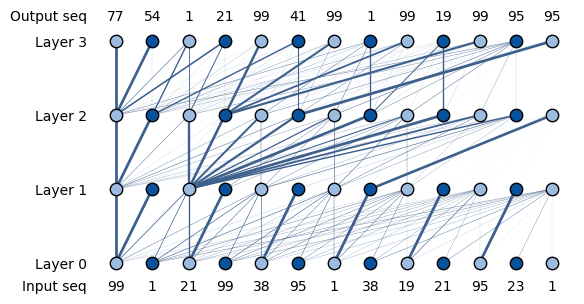

In [3]:
# 这里有3个来自不同数据集的seq，同学们可以自行替换，来观察不同数据集的attn
# input_seq = [13, 72, 72, 12, 38, 13, 78, 8, 8, 84, 12, 78, 12]  # train data，标签为8
input_seq = [99, 1, 21, 99, 38, 95, 1, 38, 19, 21, 95, 23, 1]  # test data，标签为95
# input_seq = [13, 72, 72, 12, 38, 13, 78, 8, 12, 78, 8, 84, 12]  # OOD data，标签为8

dec_logits, _ = model(torch.tensor([input_seq]).to(device))

output_seq = dec_logits.argmax(axis=-1)[0].cpu().detach().numpy()

attn_list = [attn[0][0].detach().numpy() for attn in model.decoder.dec_self_attns]

plot_info_broadcast(input_seq, output_seq, attn_list, save_path=None)

为使得信息传递路径（逻辑电路）更加清晰，我们把对最终结果产生重要影响的token和信息传递路径（逻辑电路）进行标注

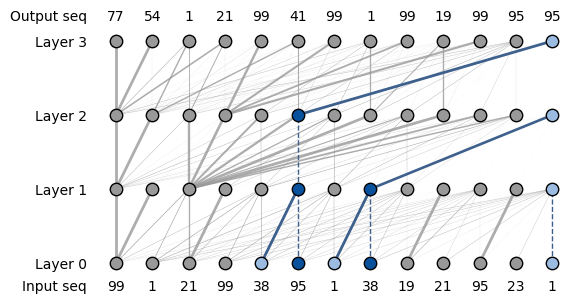

In [4]:
key_points = [(0,4), (0,5), (0,6), (0,7), (0,12), (1,5), (1,7), (1,12), (2,5), (2,12), (3,12)] # 第几层第几token标注为彩色
res_flows = [(0,5), (0,7), (0,12), (1,5)] # 第几层第几token的残差流标注为彩色
key_flows = [(0,4,5), (0,6,7), (1,7,12), (2,5,12)] # 第几层第几token到下一层第几token的attn流标注为彩色
# plot_info_broadcast(input_seq, output_seq, attn_list, key_points, key_flows, res_flows, save_path=None)
plot_info_broadcast(input_seq, output_seq, attn_list, key_points, key_flows, res_flows, save_path=f'{working_dir}/info_flow.png')

下图中，我们对于以上的信息流进行进一步地美化，同时，我们在每个关键token处标注了它所携带的信息。但这些信息并不一定在每层的attn中都是有用的，我们把在attn中激活的信息标注为红色，以便进一步观察其机制。可以观察到，模型的“推理层”总是利用两个token间有相同的信息从而使其互相关注，从而实现信息间的传递。

![info_flow_3L1H](fig/info_flow_3L1H.png "Magic Gardens")